In [1]:
#from mpl_toolkits.basemap import Basemap, cm
import os.path
import sys
from matplotlib import rcParams
from matplotlib.animation import ArtistAnimation
import matplotlib
import matplotlib.pyplot as plt
import pyart
from siphon.radarserver import RadarServer
from datetime import datetime, timedelta
from siphon.cdmr import Dataset
import pyart
import numpy as np
import numpy.ma as ma
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy.ma as ma
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from metpy.calc import (bunkers_storm_motion, bulk_shear, dewpoint, dry_lapse, moist_lapse, vapor_pressure, saturation_vapor_pressure,
                        wind_speed, wind_direction, pressure_to_height_std, mixing_ratio, cape_cin, wind_components,
                        height_to_pressure_std, equivalent_potential_temperature, parcel_profile, precipitable_water,
                        storm_relative_helicity, mean_pressure_weighted, most_unstable_cape_cin, most_unstable_parcel,
                        supercell_composite, significant_tornado, get_layer, relative_humidity_from_dewpoint)
from metpy.calc import dewpoint_from_relative_humidity as dewpoint_rh
from metpy.calc.tools import get_layer, get_layer_heights
from metpy.calc import wind_direction
from metpy.units import units
from metpy.calc import lcl
import metpy.calc as metcalc
from metpy.interpolate import interpolate_1d as metinterp
from metpy.interpolate import log_interpolate_1d as log_interp
import scipy.ndimage as ndimage
import matplotlib.gridspec as gridspec
from metpy.plots import SkewT
from metpy.plots import Hodograph
import metpy.calc as mpcalc

# import sharppy
# import sharppy.sharptab.profile as profile
# import sharppy.sharptab.interp as interp
# import sharppy.sharptab.winds as winds
# import sharppy.sharptab.utils as utils
# import sharppy.sharptab.params as params
# import sharppy.sharptab.thermo as thermo

import pickle
import csv

from scipy import stats
import matplotlib.lines as mlines


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:22: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion(duck_array_module.__version__)
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\xarray\core\pycompat.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  duck_array_version = LooseVersion("0.0.0")
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\matts\anaconda3\envs\spork2022\lib\site-packages\setuptools\_distutils\version

In [2]:
#Read in the sounding data from the spreadsheet
#Bring in the sounding data
CIsoundings=np.genfromtxt('SupercellSoundings/environment_cicases_Final.csv',skip_header=1,delimiter=',', dtype=str)
Oldsoundings=np.genfromtxt('SupercellSoundings/environment_Oldcases.csv',delimiter=',', dtype=str)
# ETsoundings=np.genfromtxt('PythonEnvVars1.csv', skip_header=1,delimiter=',')
# ETsoundings[ETsoundings==-9999]=np.nan

NewSoundings=np.genfromtxt('SupercellSoundingsNew/environment_cicases1022.csv', delimiter=',', dtype=str)

TORsondes = pickle.load(open('TORsondes.pkl', 'rb'))
NTORsondes = pickle.load(open('NTORsondes.pkl', 'rb'))
ETORsondes = pickle.load(open('ETORsondes.pkl', 'rb'))
ENTORsondes = pickle.load(open('ENTORsondes.pkl', 'rb'))
TTorsondes = pickle.load(open('TTorsondes.pkl', 'rb'))
TNTsondes = pickle.load(open('TNTsondes.pkl', 'rb'))
STsondes = pickle.load(open('STsondes.pkl', 'rb'))
SNsondes = pickle.load(open('SNsondes.pkl', 'rb'))

ALL_sites1 = pickle.load(open('ALLVARSite.pkl', 'rb'))
ALL_years1 = pickle.load(open('ALLVARYear.pkl', 'rb'))
ALL_months1 = pickle.load(open('ALLVARMonth.pkl', 'rb'))
ALL_days1 = pickle.load(open('ALLVARDay.pkl', 'rb'))
ALL_hours1 = pickle.load(open('ALLVARHour.pkl', 'rb'))
ALL_TN1 = pickle.load(open('ALLVARTor_Non.pkl', 'rb'))

ALL_b_t1 = np.zeros((ALL_TN1.shape))
ALL_b_t1[ALL_TN1=='T'] = 1.0

#Fix the incorrect entry here
ALL_sites1[44] = 'KTLX'
ALL_years1[44] = 2019
ALL_months1[44] = 3
ALL_days1[44] = 23
ALL_hours1[44] = 23
ALL_TN1[44] = 'N'

#Fix second incorrect entry here
ALL_sites1[54] = 'KFDR'
ALL_years1[54] = 2013
ALL_months1[54] = 4
ALL_days1[54] = 18
ALL_hours1[54] = 1
ALL_TN1[54] = 'T'

#Fix third incorrect entry here
ALL_sites1[61] = 'KENX'
ALL_years1[61] = 2014
ALL_months1[61] = 7
ALL_days1[61] = 3
ALL_hours1[61] = 21
ALL_TN1[61] = 'N'

obsd_TOR = pickle.load(open('sp6_dir_TOR.pkl', 'rb'))
obsd_NTOR = pickle.load(open('sp6_dir_NTOR.pkl', 'rb'))
obsd_ETOR = pickle.load(open('sp6_dir_ETOR.pkl', 'rb'))
obsd_ENTOR = pickle.load(open('sp6_dir_ENTOR.pkl', 'rb'))
obsd_TTor = pickle.load(open('sp6_dir_TTor.pkl', 'rb'))
obsd_TNT = pickle.load(open('sp6_dir_TNT.pkl', 'rb'))
obsd_ST = pickle.load(open('sp6_dir_ST.pkl', 'rb'))
obsd_SN = pickle.load(open('sp6_dir_SN.pkl', 'rb'))

obspd_TOR = pickle.load(open('sp6_sp_TOR.pkl', 'rb'))
obspd_NTOR = pickle.load(open('sp6_sp_NTOR.pkl', 'rb'))
obspd_ETOR = pickle.load(open('sp6_sp_ETOR.pkl', 'rb'))
obspd_ENTOR = pickle.load(open('sp6_sp_ENTOR.pkl', 'rb'))
obspd_TTor = pickle.load(open('sp6_sp_TTor.pkl', 'rb'))
obspd_TNT = pickle.load(open('sp6_sp_TNT.pkl', 'rb'))
obspd_ST = pickle.load(open('sp6_sp_ST.pkl', 'rb'))
obspd_SN = pickle.load(open('sp6_sp_SN.pkl', 'rb'))

#Create the full arrays for storm speed and direction
#all_dir = np.concatenate([obsd_TOR, obsd_NTOR, obsd_ETOR, obsd_ENTOR, obsd_TTor, obsd_TNT, obsd_ST, obsd_SN], axis=0)
#all_spd = np.concatenate([obspd_TOR, obspd_NTOR, obspd_ETOR, obspd_ENTOR, obspd_TTor, obspd_TNT, obspd_ST, obspd_SN], axis=0)


NewCases = np.genfromtxt('SPORK_rerun_new.csv', delimiter=',', usecols=(0,2,3,4,7,17),skip_header=1, dtype=int)
NewCases1 = np.genfromtxt('SPORK_rerun_new.csv', delimiter=',', usecols=(0,2,3,4,7,17), dtype=str, skip_header=1)

print(NewCases[0,:])
print(NewCases1[0,:])

ALL_sites2 = NewCases1[:,0]
ALL_years2 = NewCases[:,1]
ALL_months2 = NewCases[:,2]
ALL_days2 = NewCases[:,3]
ALL_hours2 = NewCases[:,4]
ALL_TN2 = np.copy(ALL_sites2)
ALL_TN2[:] = 'TR'
ffds2 = NewCases[:,5]
print(ffds2)


NewCases2 = np.genfromtxt('New2023CSV.csv', delimiter=',', skip_header=1, dtype=int)
NewCases3 = np.genfromtxt('New2023CSV.csv', delimiter=',', dtype=str, skip_header=1)


ALL_sites3 = NewCases3[:,0]
ALL_years3 = NewCases2[:,2]
ALL_months3 = NewCases2[:,3]
ALL_days3 = NewCases2[:,4]
ALL_hours3 = NewCases2[:,7]
ALL_TN3 = np.copy(ALL_sites3)
ALL_TN3[:] = 'TR'
ffds3 = NewCases2[:,14]
print(ffds3)
#ALL_TN = pickle.load(open('ALLVARTor_Non.pkl', 'rb'))


ALL_sites = np.concatenate([ALL_sites1, ALL_sites2, ALL_sites3], axis=0)
ALL_years = np.concatenate([ALL_years1, ALL_years2, ALL_years3], axis=0)
ALL_months = np.concatenate([ALL_months1, ALL_months2, ALL_months3], axis=0)
ALL_days = np.concatenate([ALL_days1, ALL_days2, ALL_days3], axis=0)
ALL_hours = np.concatenate([ALL_hours1, ALL_hours2, ALL_hours3], axis=0)
ALL_TN = np.concatenate([ALL_TN1, ALL_TN2, ALL_TN3], axis=0)

[  -1 2021    6   19    0  220]
['KIND' '2021' '6' '19' '0' '220']
[220 160 190 145 200 140 160 180 110 170 120 170 165 140 150 140 140 170
 170 150 150 130 150 130 140 190 180 180 180 180 130  70 170 200 200 190
 190 120 130 140 200 200 180 220 190 180 190 160 160 150 160 150 160 180
 140 150 140 170 150 160 180 180 210 230 190 230 180 180 150 130 190 240
 170 130 190 160 130 150 180 180 190 190 180 230 150 150 200 230 170 190
 140 150 150 220 160 190 180 180 160 170 180 150 160 150]
[180 180 180 150 180 190 140 180 130 150 160 190 150 160 160 160 170 190
 180 180 170 140 210 160 160 220 210 210 160 180 190 170 150 180 170 180
 190 150 170 180 160 160 160 180 160 160 210 150 180 140 120 140 170 160
 170 150 220 170 160 190 210 210 200 200 240 210 200 220 130 210 190 210
 230 180 210 180 150 190 180 170 160 140 140 200 200 190 210 240 190 240
 200 160 200 190 170 190 200 190 210]


C:\Users\matts\AppData\Local\Temp\ipykernel_78492\729292806.py:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cg=plt.colorbar(refl)


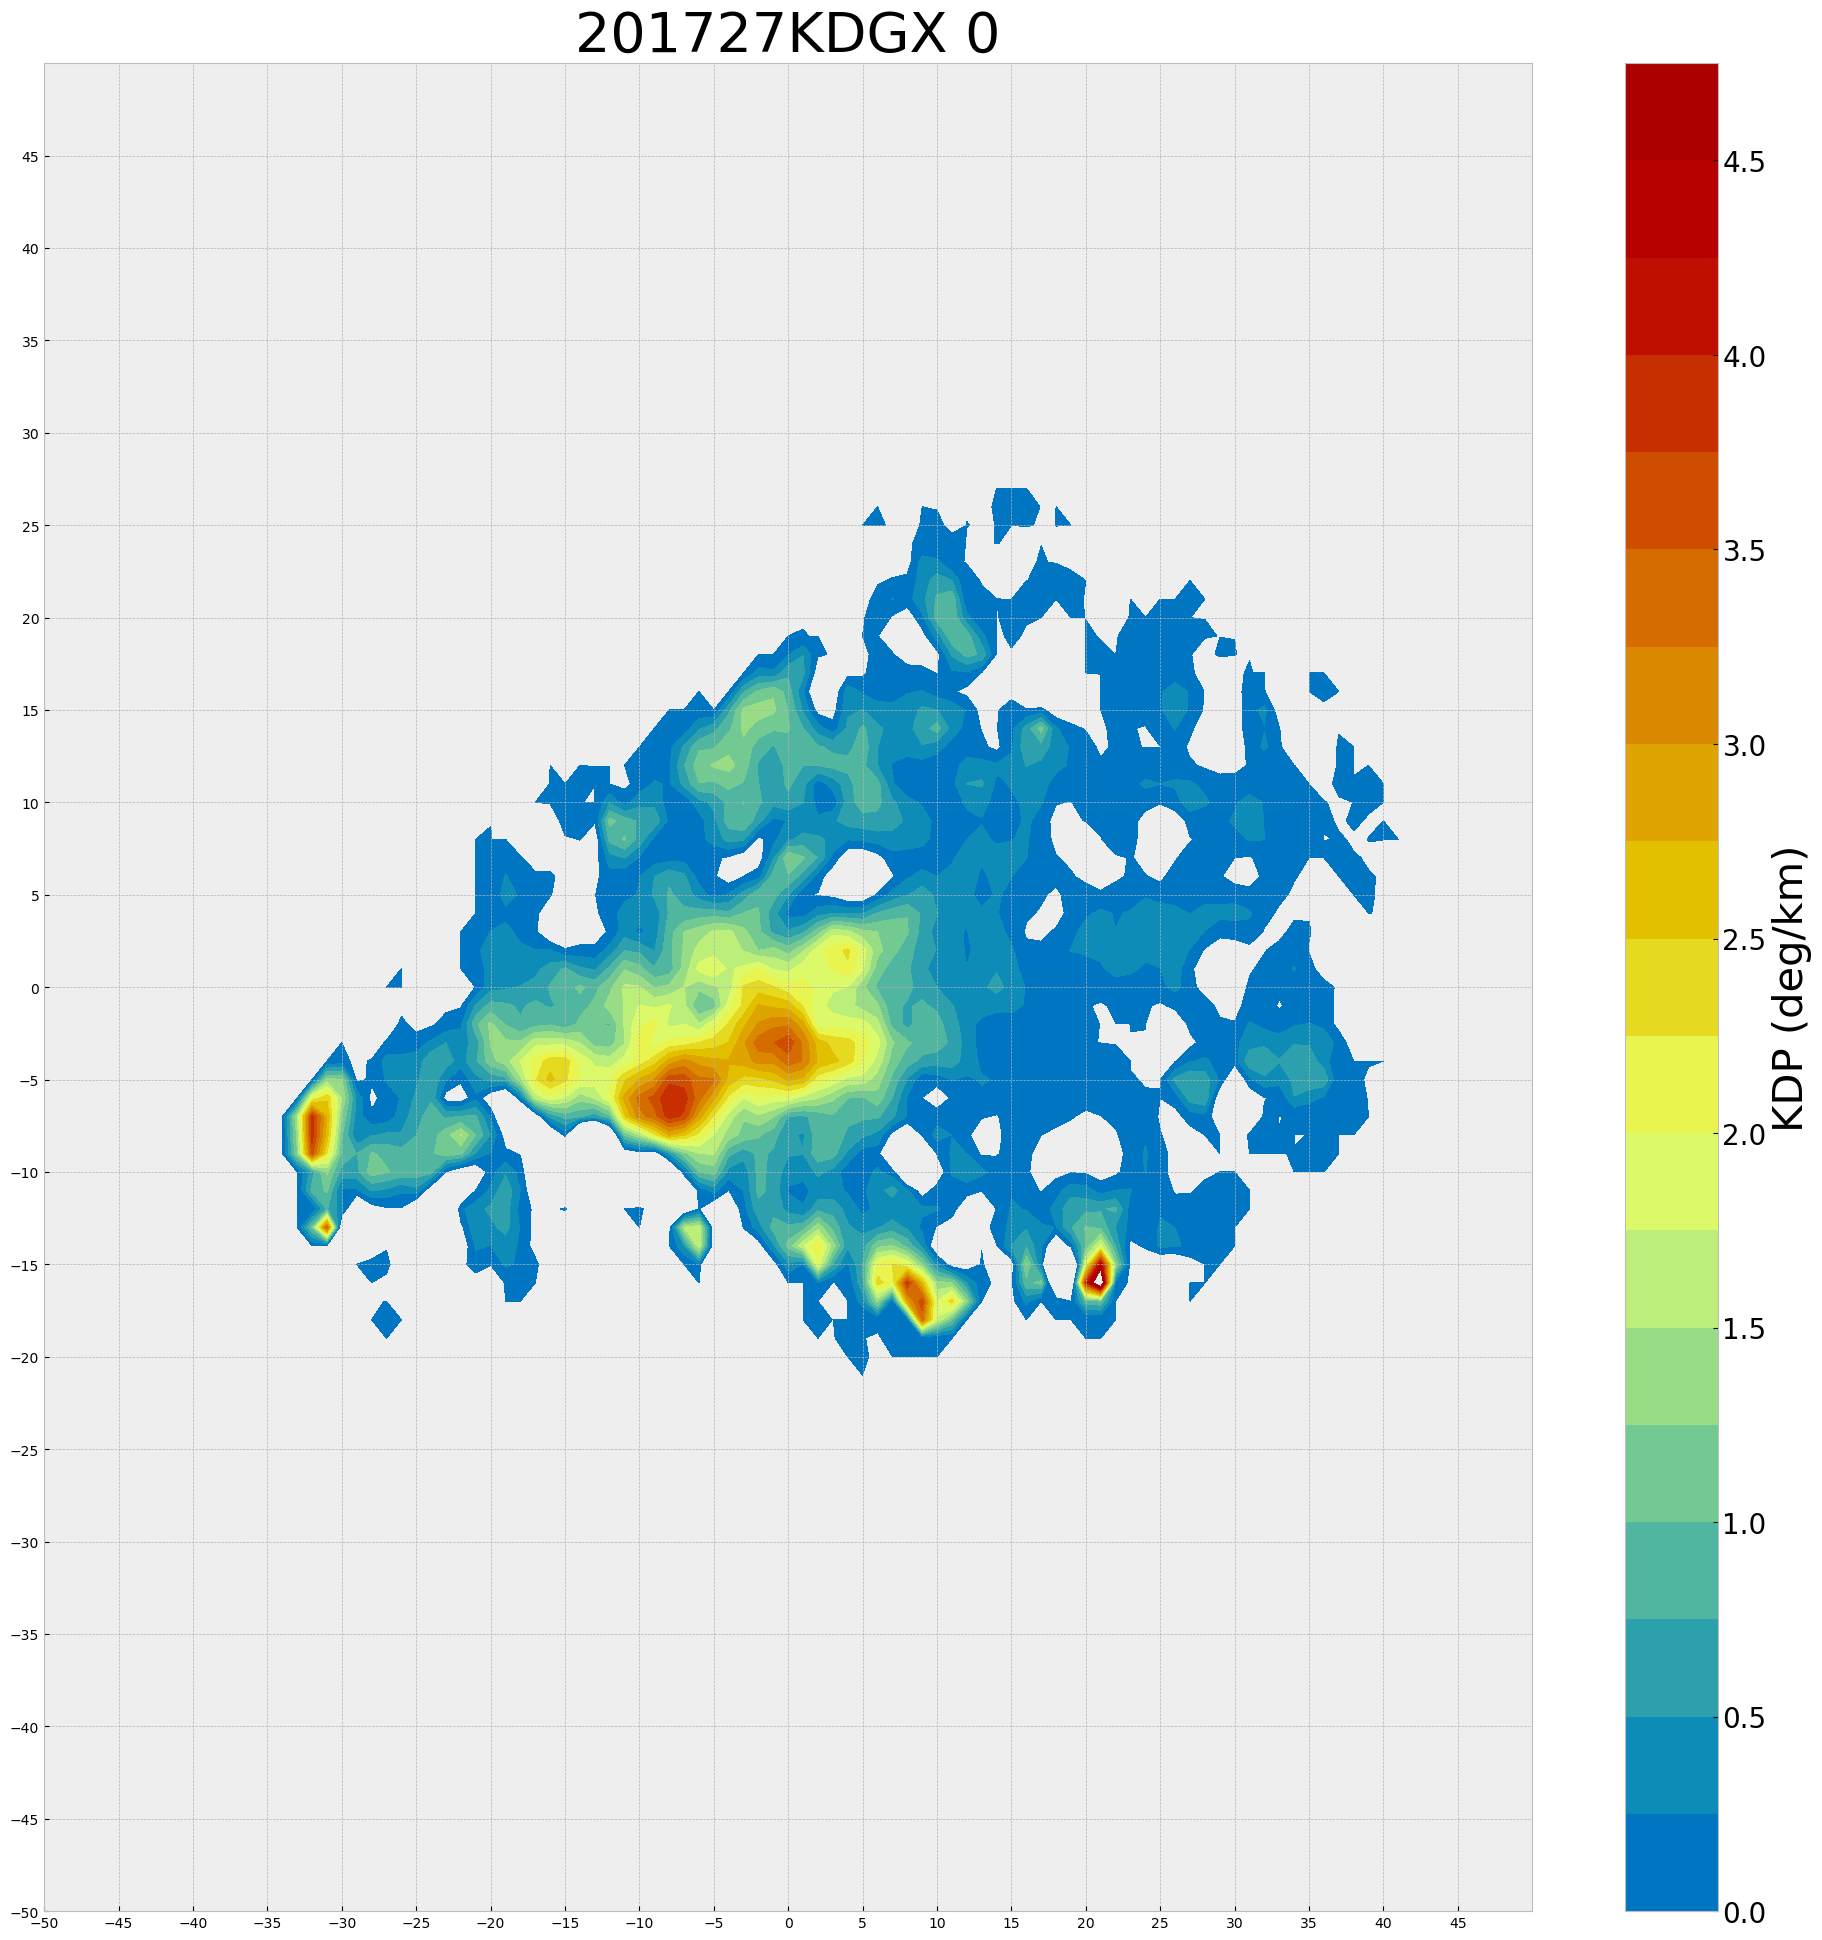

In [16]:
rotlev1 = np.arange(-0.02,0.022, 0.002)



plt.style.use('bmh')
xr2 = np.arange(0, 100, 1)
xr2 = xr2 - 50
xr11=xr2
yr11=xr2
#for i in HSLC_index[0]:
#for i in [0]:
#for i in np.arange(0,408,1):
for i in [0]:
    #print(i)
    plt.figure(i+20, figsize=(24,24))
    #postage = pickle.load(open('SPORK_AC_ROTATE'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
    postage = pickle.load(open('SPORK_1_ROTATE'+str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+'.pkl', 'rb'))
    
#     ref_array[i,:,:] = postage[2]
#     rot1_array[i,:,:] = postage[3]
#     rot3_array[i,:,:] = postage[4]
#     rot5_array[i,:,:] = postage[5]    
#     rot7_array[i,:,:] = postage[6]
#     zdrd_array[i,:,:] = postage[7]    
#     nzdr_array[i,:,:] = postage[8]
#     zdr_array[i,:,:] = postage[9]
#     kdp_array[i,:,:] = postage[10]
#     cc_array[i,:,:] = postage[11] 
#     refp2 = plt.contour(xr11, yr11, postage[2], [35], colors='grey', linewidths=5, zorder=5, alpha=0.5)
#     refp2 = plt.contour(xr11, yr11, postage[3], [0.0025], colors='r', linewidths=5, zorder=6)
#     refp2 = plt.contour(xr11, yr11, postage[3], [-0.0025], colors='b', linewidths=5, zorder=6)
    #plt.contour(xr2, xr2, postage[4], rotlev1, cmap=plt.cm.seismic, linewidths=5)
    #plt.contour(xr2, xr2, postage[7], [4], colors='cyan', linewidths=5)
    #plt.contourf(xr2, xr2, postage[2], [30], cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    #refl=plt.contourf(xr2, xr2, postage[2], np.arange(25,80,2), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    refl=plt.contourf(xr2, xr2, postage[10], np.arange(0,5,0.25), cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    #plt.contour(xr2, xr2, postage[3], [0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015], colors='k', linewidths=5)
    cg=plt.colorbar(refl)
    cg.ax.tick_params(labelsize=20)
    #cg.set_label("Reflectivity (dBZ)",size = 30)
    cg.set_label("KDP (deg/km)",size = 30)
    #refp2 = plt.contour(xr11, yr11, rot1_pm, [0.00125,0.0025,0.005], colors='k', linewidths=5, zorder=6)
    plt.title(str(ALL_years[i])+str(ALL_months[i])+str(ALL_days[i])+str(ALL_sites[i])+' '+str(i), size=40)
    plt.xlim(-50,50)
    plt.ylim(-50,50)
    plt.xticks(np.arange(-50,50,5))
    plt.yticks(np.arange(-50,50,5))
    
    #plt.savefig('Recenter_plots/OneFrameStorm'+str(i)+'_test.png')


    #refp2 = plt.contour(xr11, yr11, postage[5], [0.005], colors='purple', linewidths=5, zorder=6)        

In [ ]:
#Cases/indices to spot check correction: 
#319
#333
#344
#345

In [ ]:
thingy = datetime(2017,2,4,21,13)
#thingy = None

if thingy:
    print('hi')
else:
    print('howdy')